In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from matplotlib.animation import FuncAnimation
from pyDOE import lhs
import math
from matplotlib import rcParams
rcParams['font.family'] = "serif"       # Setting the font in graphs etc
rcParams['font.size'] = 16

A_m_theory = 1.506484

### Mandelbrot functions

In [11]:
# mandelbrot algorithm
@jit(nopython=True)
def mandelbroth(real, imaginary, max_iter):

    c = complex(real, imaginary)
    z = 0.0j
    
    for i in range(max_iter):
        z = z * z + c
        if np.abs(z) >= 2:
            return i
        
    return max_iter

# run mandelbrot for given grid range`
@jit(nopython=True)
def mandelbrot_set(real, imaginary, max_iter=100):

    mandelbrot = np.zeros((len(real), len(imaginary)), dtype=np.int64)

    for i in range(len(real)):
        # if i % 100 == 0:
        #     print(f"i={i}")
        for j in range(len(imaginary)):
            mandelbrot[i, j] = mandelbroth(real[i], imaginary[j], max_iter)

    return mandelbrot


### Animation functions

In [ ]:
def find_edge_coordinates(mandelbrot_set):
    
    edge_coords = np.argwhere(mandelbrot_set[:-1, :-1] != mandelbrot_set[1:, 1:])
    return edge_coords

# realign animation to follow edge of mandelbrot
def update(frame):
    global real_values, imaginary_values
    if frame % 50 == 0:
        print(f"current frame: {frame}")
    mandelbrot = mandelbrot_set(real_values, imaginary_values, max_iter=500)
    edge_coords = find_edge_coordinates(mandelbrot)

    if len(edge_coords) == 0:
        return

    edge_x, edge_y = np.mean(edge_coords, axis=0)
    
    center_real = real_values[int(edge_x)]
    center_imag = imaginary_values[int(edge_y)]

    zoom_factor = 0.95

    real_values = real_values * zoom_factor + (1 - zoom_factor) * center_real
    imaginary_values = imaginary_values * zoom_factor + (1 - zoom_factor) * center_imag

    # Recalculate Mandelbrot set and update plot
    mandelbrot = mandelbrot_set(real_values, imaginary_values)
    im.set_array(mandelbrot.T)
    im.set_extent([real_values[0], real_values[-1], imaginary_values[0], imaginary_values[-1]])

    return [im]

### Sampling functions

In [12]:
# random monte carlo premade array
def monte_carlo(samples, array):

    array_size = array.shape[0]

    # we can recognize the max iterations since it will be the max in array
    max_iter = np.max(array)
    total_area = 3 * 3  # (1 - (-2)) * (1.5 - (-1.5)) (misschien beter om niet te hardcoden?)
    x = np.random.randint(0, array_size, size=samples)
    y = np.random.randint(0, array_size, size=samples)
    
    inside = np.sum(array[x, y] == max_iter)
    
    return (inside / samples) * total_area

# Latin Hypercube sampling
def latin_hypercube(n_samples, array):
        
    # Generate Latin Hypercube Samples in 2 dimensions
    samples = lhs(2, samples=n_samples, criterion='c')
    
    # scale samples to array size and convert to int
    scaled_samples = samples * array.shape[0]
    x,y = scaled_samples.astype(int).T
    
    max_iter = np.max(array)
    inside = np.sum(array[x,y] == max_iter)
    
    return (inside / n_samples) * 9

def create_strata(n_sub):
    len_sub = 3/n_sub
    subsections = []
    x_min = -2
    for _ in range(n_sub):
        y_min = -1.5
        x_max = x_min + len_sub 
        for _ in range(n_sub):
            y_max = y_min + len_sub
            subsections.append([x_min, x_max, y_min, y_max])
            y_min+= len_sub
        x_min+= len_sub 
            
    return subsections

def create_subspace(n_sub, len_array):
    len_sub = len_array/n_sub
    subsections = []
    x_min = 0
    for _ in range(n_sub):
        y_min = 0
        x_max = x_min + len_sub 
        for _ in range(n_sub):
            y_max = y_min + len_sub
            subsections.append([x_min, x_max, y_min, y_max])
            y_min+= len_sub
        x_min+= len_sub 
            
    return subsections

# Orthogonal sampling
def orthogonal(n_samples, array):
    # define subspaces
    n_sub = 3
    sub_samples = int(n_samples/(n_sub**2))
    subspaces = create_subspace(n_sub, array.shape[0])
            
    # iterate through sections
    max_iter = np.max(array)
    area = 0
    for subspace in subspaces:
        samples = lhs(2, samples=sub_samples, criterion='c')
        
        new_min = np.array([subspace[0], subspace[2]])  # Minimum values for X and Y dimensions
        new_max = np.array([subspace[1], subspace[3]])   # Maximum values for X and Y dimensions

        # Scale and shift the LHS samples to the new range
        shifted_samples = new_min + samples * (new_max - new_min)
        x,y = shifted_samples.astype(int).T
        
        area+= np.sum(array[x,y] == max_iter)
    
    return (area / n_samples) * 9

# random monte carlo without array, so all points can be calculated
def monte_carlo_no_array(samples, max_iter = 500):

    # Setting the ranges and calculating the total area
    x = np.random.uniform(-2, 1, size=samples)
    y = np.random.uniform(-1.5, 1.5, size=samples)
    total_area = 3 * 3  
    
    inside = 0

    # sample n random points and check if they are inside the mandelbrot set
    for i in range(samples):
        iters = mandelbroth(x[i], y[i], max_iter)
        if iters == max_iter:
            inside += 1

    return (inside / samples) * total_area

def adaptive_stratified_monte_carlo(samples, max_iter, strata, initial_sample_fraction=0.2):
    total_area = 3 * 3  # Total area of the sampled region
    initial_samples = int(samples * initial_sample_fraction)
    remaining_samples = samples - initial_samples
    inside_rates = []
    estimated_area = 0

    # Initial sampling to estimate densities
    for (x_min, x_max, y_min, y_max) in strata:
        local_samples = math.ceil(initial_samples * ((x_max - x_min) * (y_max - y_min) / total_area))
        x = np.random.uniform(x_min, x_max, local_samples)
        y = np.random.uniform(y_min, y_max, local_samples)
        inside = sum(mandelbroth(x[i], y[i], max_iter) == max_iter for i in range(local_samples))
        inside_rates.append(inside / local_samples)

    # Allocate more samples to denser strata
    total_inside_rate = sum(inside_rates)
    for idx, (x_min, x_max, y_min, y_max) in enumerate(strata):
        local_samples = math.ceil(remaining_samples * (inside_rates[idx] / total_inside_rate))
        x = np.random.uniform(x_min, x_max, local_samples)
        y = np.random.uniform(y_min, y_max, local_samples)
        inside = sum(mandelbroth(x[i], y[i], max_iter) == max_iter for i in range(local_samples))

        stratum_area = (x_max - x_min) * (y_max - y_min)
        if local_samples > 0:
            estimated_area += (inside / local_samples) * stratum_area

    return estimated_area


### Full Mandelbrot plot

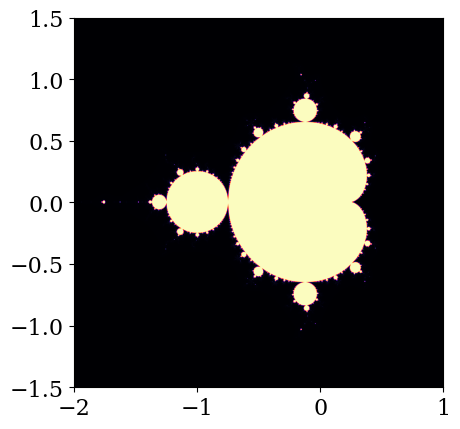

In [19]:
# set range for calculating mandelbrot
real = np.linspace(-2,1,5000)
imaginary = np.linspace(-1.5,1.5,5000)

# creates a 2D array of the mandelbrot set 
mandelbrot = mandelbrot_set(real, imaginary, max_iter=1500).T

plt.imshow(mandelbrot, extent = [-2,1,-1.5,1.5], cmap='magma')
# plt.savefig("Fractal.png",dpi= 5000)
plt.show()

### Animation

In [ ]:
# initialize range to calculate
real_values = np.linspace(-2, 1, 1500)
imaginary_values = np.linspace(-1.5, 1.5, 1500)

# run and plot mandelbrot algorithm
mandelbrot = mandelbrot_set(real_values, imaginary_values)

fig, ax = plt.subplots()
im = ax.imshow(mandelbrot.T, extent=[-2, 1, -1.5, 1.5], animated=True)

# Create animation
ani = FuncAnimation(fig, update, frames=500, blit=True)
ani.save('mandel_zoomnew.gif', writer='pillow', fps=30)
plt.show()


In [23]:
iterations = np.linspace(10,1000,50, dtype=int)  # From 10^0=1 to 10^3=1000, 50 points
samples = np.logspace(2, 7, 50, dtype=int)  # From 10^2=100 to 10^6=1,000,000, 50 points
M_sets_iter = []

for i, iter in enumerate(iterations):
    print(f"Current iteration is {iter}")
    M_sets_iter.append(mandelbrot_set(real_values, imaginary_values, max_iter=iter))

Current iteration is 10
Current iteration is 30
Current iteration is 50
Current iteration is 70
Current iteration is 90
Current iteration is 111
Current iteration is 131
Current iteration is 151
Current iteration is 171
Current iteration is 191
Current iteration is 212
Current iteration is 232
Current iteration is 252
Current iteration is 272
Current iteration is 292
Current iteration is 313
Current iteration is 333
Current iteration is 353
Current iteration is 373
Current iteration is 393
Current iteration is 414
Current iteration is 434
Current iteration is 454
Current iteration is 474
Current iteration is 494
Current iteration is 515
Current iteration is 535
Current iteration is 555
Current iteration is 575
Current iteration is 595
Current iteration is 616
Current iteration is 636
Current iteration is 656
Current iteration is 676
Current iteration is 696
Current iteration is 717
Current iteration is 737
Current iteration is 757
Current iteration is 777
Current iteration is 797
Curre

### Random Monte Carlo sampling premade array


In [17]:
real_values = np.linspace(-2, 1, 10000)
imaginary_values = np.linspace(-1.5, 1.5, 10000)

mandel_ours = mandelbrot_set(real_values, imaginary_values, max_iter=1500)
A_m_ours = monte_carlo(25_000_000, mandel_ours)

# found at: https://www2.pd.infn.it/~lacaprar/Didattica/C++/Complex/Area%20of%20the%20Mandelbrot%20Set.pdf
A_m_theory = 1.506484
print(f"The area of the Mandelbrot set (theory) is {A_m_theory:.4f}")
print(f"The area of the Mandelbrot set according to our montecarlo (s=10m, i= 1000) is {A_m_ours:.4f}")


The area of the Mandelbrot set (theory) is 1.5065
The area of the Mandelbrot set according to our montecarlo (s=10m, i= 1000) is 1.5084


### Random Monte Carlo sampling no array


In [137]:
real_values = np.linspace(-2, 1, 10000)
imaginary_values = np.linspace(-1.5, 1.5, 10000)

A_m_ours_no_array = monte_carlo_no_array(25_000_000, max_iter=1500)

# found at: https://www2.pd.infn.it/~lacaprar/Didattica/C++/Complex/Area%20of%20the%20Mandelbrot%20Set.pdf
A_m_theory = 1.506484
print(f"The area of the Mandelbrot set (theory) is {A_m_theory:.4f}")
print(f"The area of the Mandelbrot set according to our montecarlo (s=25m, i= 1000) is {A_m_ours_no_array:.4f}")


The area of the Mandelbrot set (theory) is 1.5065
The area of the Mandelbrot set according to our montecarlo (s=25m, i= 1000) is 1.5101


In [21]:
mandelbrot_array

TypeError: 'tuple' object is not callable

In [15]:
iterations = np.linspace(10,1000,50, dtype=int)  # From 10^0=1 to 10^3=1000, 50 points
samples = np.logspace(2, 7, 50, dtype=int)  # From 10^2=100 to 10^6=1,000,000, 50 points

# Initialize the areas array to be of shape (len(iterations), len(samples))
areas = np.zeros((len(iterations), len(samples)))

real_values = np.linspace(-2, 1, 2000)
imaginary_values = np.linspace(-1.5, 1.5, 2000)


for i, iter in enumerate(iterations):
    print(f"Current iteration is {iter}")
    mandelbrot_array = mandelbrot_set(real_values, imaginary_values, max_iter=iter)
    
    for j, s in enumerate(samples):
        for _ in range(15):
            area_dx = np.abs(monte_carlo(s, mandelbrot_array) - A_m_theory) / 15
            areas[i, j] += area_dx

Current iteration is 10
Current iteration is 30
Current iteration is 50
Current iteration is 70
Current iteration is 90
Current iteration is 111
Current iteration is 131
Current iteration is 151
Current iteration is 171
Current iteration is 191
Current iteration is 212
Current iteration is 232
Current iteration is 252
Current iteration is 272
Current iteration is 292
Current iteration is 313
Current iteration is 333
Current iteration is 353
Current iteration is 373
Current iteration is 393
Current iteration is 414
Current iteration is 434
Current iteration is 454
Current iteration is 474
Current iteration is 494
Current iteration is 515
Current iteration is 535
Current iteration is 555
Current iteration is 575
Current iteration is 595
Current iteration is 616
Current iteration is 636
Current iteration is 656
Current iteration is 676
Current iteration is 696
Current iteration is 717
Current iteration is 737
Current iteration is 757
Current iteration is 777
Current iteration is 797
Curre

Text(0.5, 1, 'Convergence Behavior of $A_i,s$ for Iterations=212')

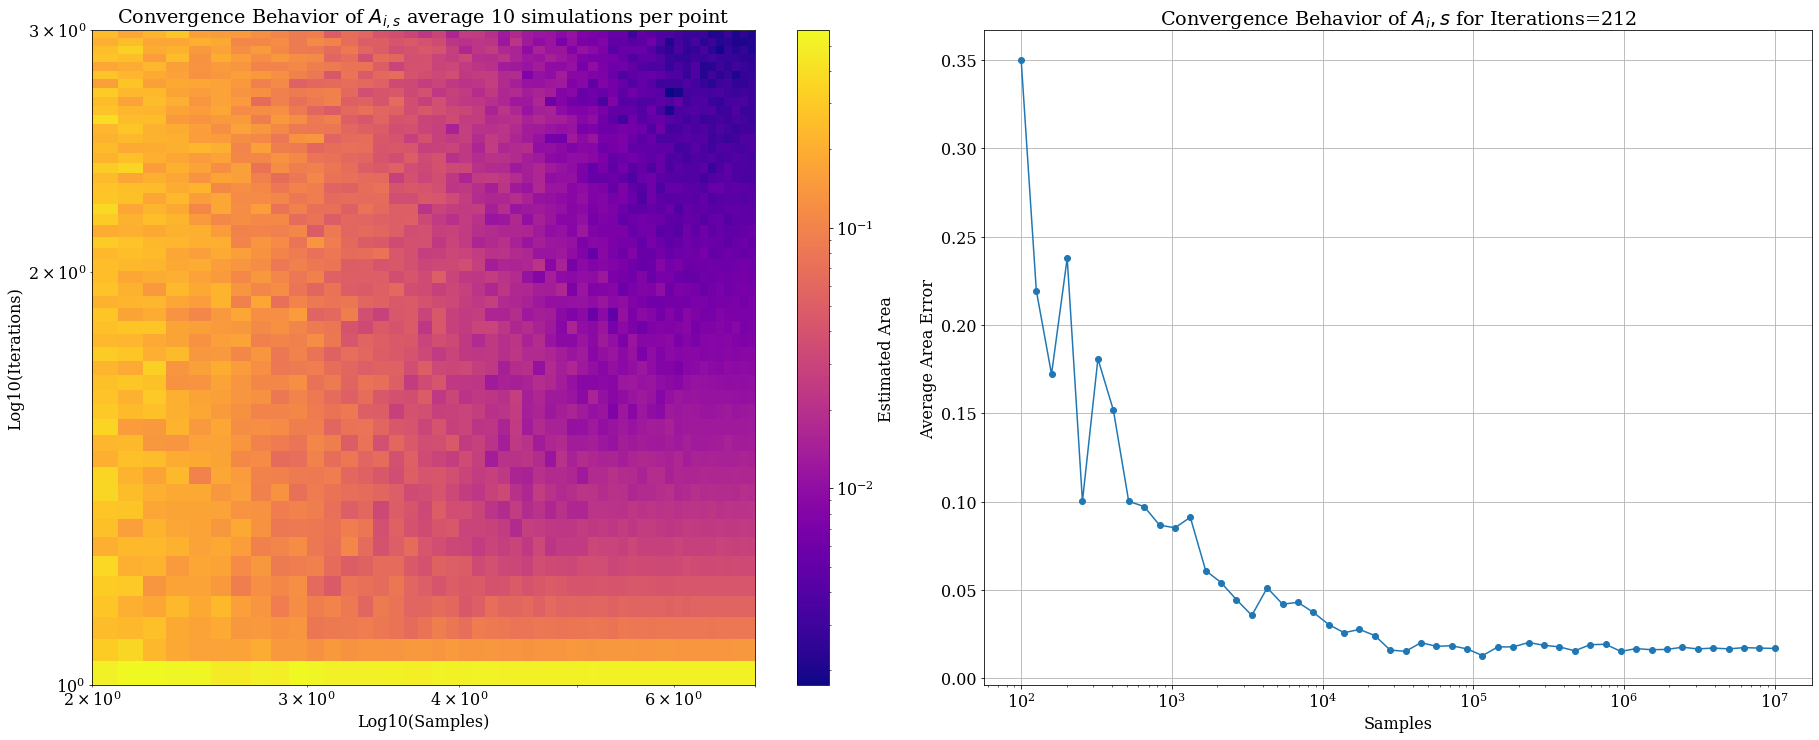

In [154]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,2, figsize=[25,10], gridspec_kw={'width_ratios': [1,1]})
# fig.tight_layout()

# plt.figure(figsize=(10, 8))
c = ax[0].imshow(areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[np.log10(samples[0]), np.log10(samples[-1]), np.log10(iterations[0]), np.log10(iterations[-1])])


fig.colorbar(c, label='Estimated Area', ax=ax[0])
ax[0].set_xlabel('Log10(Samples)')
ax[0].set_ylabel('Log10(Iterations)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].xaxis.set_ticks(np.log10(samples)[::10], samples[::10])
# ax[0].set_yticks(np.log10(iterations)[::10], iterations[::10])
ax[0].set_title('Convergence Behavior of $A_{i,s}$ average 10 simulations per point')

# Additional Line plot for specific value of i
fixed_i_index = 10
ax[1].semilogx(samples, areas[fixed_i_index, :], '-o')
ax[1].grid(True)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Average Area Error')
ax[1].set_title(f'Convergence Behavior of $A_{"i,s"}$ for Iterations={iterations[fixed_i_index]}')


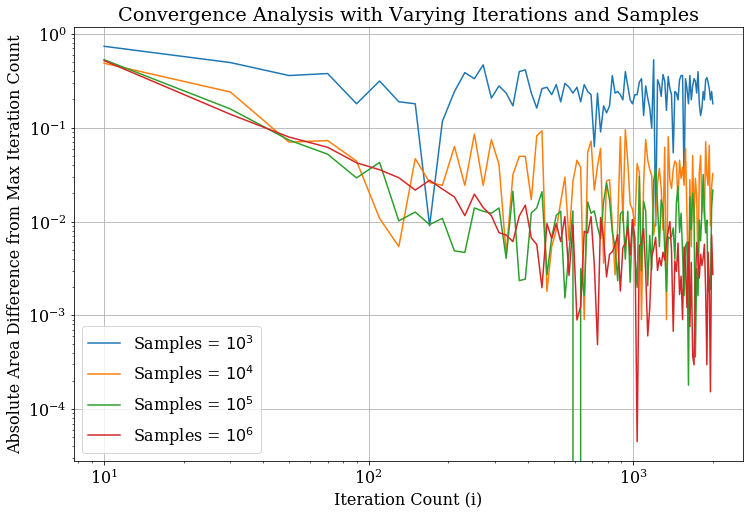

In [158]:
np.random.seed(0)

max_iter = 2000  
sample_range = np.logspace(3, 6, 4, dtype=int)  
iteration_steps = np.linspace(10, max_iter, 100, dtype=int)  

area_differences = np.zeros((len(sample_range), len(iteration_steps)))

# Compute the areas for different combinations of i and 
for s_index, s in enumerate(sample_range):

    # Calculate the area for the maximum iteration count
    area_max = monte_carlo_no_array(s, max_iter)

    for i_index, i in enumerate(iteration_steps):
        
        area_i = monte_carlo_no_array(s, i)
        area_differences[s_index, i_index] = np.abs(area_i - area_max)

plt.figure(figsize=[12,8])
# Plot the differences as a function of i for each s
for s_index, s in enumerate(sample_range):
    plt.loglog(iteration_steps, area_differences[s_index, :], label=f'Samples = $10^{s_index+3}$')

plt.xlabel('Iteration Count (i)')
plt.ylabel('Absolute Area Difference from Max Iteration Count')
plt.legend()
plt.title('Convergence Analysis with Varying Iterations and Samples')
plt.grid(True)
plt.savefig("convergence.png",dpi= 1000)
plt.show()

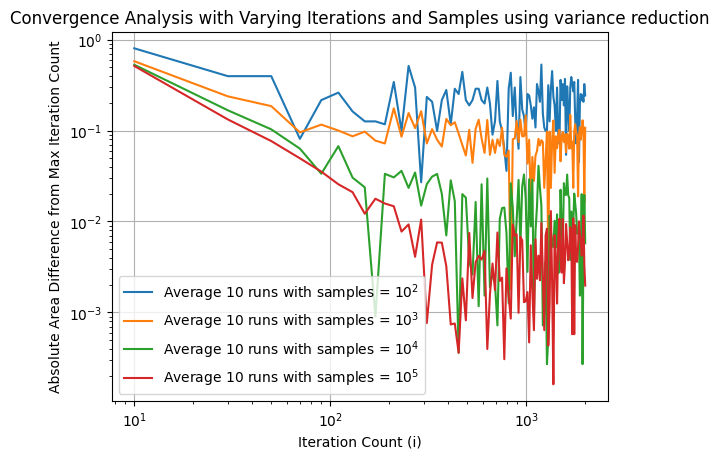

In [111]:
np.random.seed(0)
# Takes about 15 minutes to compute, change max_iter or samples to speed up

max_iter = 2000  
# varince reduction over 100 simulations so samples is 100 times smaller
# This is to have about the same computation time as the previous plot
sample_range = np.logspace(2, 5, 4, dtype=int)  
iteration_steps = np.linspace(10, max_iter, 100, dtype=int)  

area_differences = np.zeros((len(sample_range), len(iteration_steps)))

# Compute the areas for different combinations of i and 
for s_index, s in enumerate(sample_range):
    area_max = 0
    # Calculate the area for the maximum iteration count using variance reduction
    for _ in range(10):
        area_max += monte_carlo_no_array(s, max_iter)/10

    for i_index, i in enumerate(iteration_steps):
        area_i = 0
        
        # Apply variance reduction by averaging over 10 simulations
        for _ in range(10):
            area_i += monte_carlo_no_array(s, i)/10
                
        area_differences[s_index, i_index] = np.abs(area_i - area_max)

plt.figure(figsize=[12,8])
# Plot the differences as a function of i for each s
for s_index, s in enumerate(sample_range):
    plt.loglog(iteration_steps, area_differences[s_index, :], label=f'Average 10 runs with samples = $10^{s_index+2}$')

plt.xlabel('Iteration Count (i)')
plt.ylabel('Absolute Area Difference from Max Iteration Count')
plt.legend()
plt.title('Convergence Analysis with Varying Iterations and Samples using variance reduction')
plt.grid(True)
plt.savefig("convergence_var_reduction.png",dpi= 1000)
plt.show()

### Stratified Sampling
We will be dividing the complex plane into "Strata", we will be using rectangle shaped strata. And sample N samples from each strata, we will dynamically take more samples in areas with a higher "inside" rate of the random points, since these areas most likely will have the edges of the set.

In [147]:
# Define your strata (for example, a 3x3 grid)
strata = [
    (-2.0, -1.4, -1.5, -0.9), (-1.4, -0.8, -1.5, -0.9), (-0.8, -0.2, -1.5, -0.9), (-0.2, 0.4, -1.5, -0.9), (0.4, 1.0, -1.5, -0.9),
    (-2.0, -1.4, -0.9, -0.3), (-1.4, -0.8, -0.9, -0.3), (-0.8, -0.2, -0.9, -0.3), (-0.2, 0.4, -0.9, -0.3), (0.4, 1.0, -0.9, -0.3),
    (-2.0, -1.4, -0.3, 0.3), (-1.4, -0.8, -0.3, 0.3), (-0.8, -0.2, -0.3, 0.3), (-0.2, 0.4, -0.3, 0.3), (0.4, 1.0, -0.3, 0.3),
    (-2.0, -1.4, 0.3, 0.9), (-1.4, -0.8, 0.3, 0.9), (-0.8, -0.2, 0.3, 0.9), (-0.2, 0.4, 0.3, 0.9), (0.4, 1.0, 0.3, 0.9),
    (-2.0, -1.4, 0.9, 1.5), (-1.4, -0.8, 0.9, 1.5), (-0.8, -0.2, 0.9, 1.5), (-0.2, 0.4, 0.9, 1.5), (0.4, 1.0, 0.9, 1.5)
]
# Number of samples and iterations
samples = 25_000_000
max_iter = 1500

# Estimate the area
estimated_area = adaptive_stratified_monte_carlo(samples, max_iter, strata)

print("Estimated area of the Mandelbrot set using adaptive strata:", round(estimated_area,4))
print("Estimated area of the Mandelbrot set using standard MC:", round(A_m_ours_no_array,4))
print("Estimated area of the Mandelbrot set according to theory:" ,round(A_m_theory,4))

Estimated area of the Mandelbrot set using adaptive strata: 1.5094
Estimated area of the Mandelbrot set using standard MC: 1.5101
Estimated area of the Mandelbrot set using standard MC: 1.5065


In [170]:

samples = 10000  # Set a specific sample count for comparison
max_iter = 1500
num_simulations = 5000  # Number of simulations to run for each method

areas_adaptive = []
areas_no_array = []

for _ in range(num_simulations):
    if _ % 100 == 0:
        print(f"Current simulation is at {(_/num_simulations)*100}%")

    area_adaptive = adaptive_stratified_monte_carlo(samples, max_iter, strata)
    areas_adaptive.append(area_adaptive)

    area_no_array = monte_carlo_no_array(samples, max_iter)
    areas_no_array.append(area_no_array)

# Determine the range for the histograms
all_areas = areas_adaptive + areas_no_array
min_bin = min(all_areas)
max_bin = max(all_areas)
bins = np.linspace(min_bin, max_bin, 21)  # 20 bins

# Plotting the histograms
plt.figure(figsize=(12, 6))

plt.hist(areas_adaptive, bins=bins, alpha=0.7, label='Adaptive Stratified Monte Carlo')
plt.hist(areas_no_array, bins=bins, alpha=0.7, label='Normal Monte Carlo')
plt.axvline(A_m_theory, color='k', linestyle='dashed', linewidth=1, label='Theory Area')

plt.xlabel('Estimated Area')
plt.ylabel('Frequency')
plt.title(f'Histogram of Estimated Areas for {samples} Samples')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
from numpy import savetxt
savetxt('adaptive.csv', orth_areas, delimiter=',')

In [50]:
savetxt('LHS.csv', LHS_areas, delimiter=',')

In [51]:
savetxt('random.csv', areas, delimiter=',')

In [42]:
iterations = np.linspace(10,1000,50, dtype=int)  # From 10^0=1 to 10^3=1000, 50 points
samples = np.logspace(2, 7, 50, dtype=int)  # From 10^2=100 to 10^6=1,000,000, 50 points
strata = [
    (-2.0, -1.4, -1.5, -0.9), (-1.4, -0.8, -1.5, -0.9), (-0.8, -0.2, -1.5, -0.9), (-0.2, 0.4, -1.5, -0.9), (0.4, 1.0, -1.5, -0.9),
    (-2.0, -1.4, -0.9, -0.3), (-1.4, -0.8, -0.9, -0.3), (-0.8, -0.2, -0.9, -0.3), (-0.2, 0.4, -0.9, -0.3), (0.4, 1.0, -0.9, -0.3),
    (-2.0, -1.4, -0.3, 0.3), (-1.4, -0.8, -0.3, 0.3), (-0.8, -0.2, -0.3, 0.3), (-0.2, 0.4, -0.3, 0.3), (0.4, 1.0, -0.3, 0.3),
    (-2.0, -1.4, 0.3, 0.9), (-1.4, -0.8, 0.3, 0.9), (-0.8, -0.2, 0.3, 0.9), (-0.2, 0.4, 0.3, 0.9), (0.4, 1.0, 0.3, 0.9),
    (-2.0, -1.4, 0.9, 1.5), (-1.4, -0.8, 0.9, 1.5), (-0.8, -0.2, 0.9, 1.5), (-0.2, 0.4, 0.9, 1.5), (0.4, 1.0, 0.9, 1.5)
]

# Initialize the areas array to be of shape (len(iterations), len(samples))
orth_areas = np.zeros((len(iterations), len(samples)))

real_values = np.linspace(-2, 1, 2000)
imaginary_values = np.linspace(-1.5, 1.5, 2000)


for i, iter in enumerate(iterations):
    print(f"Current iteration is {iter}")
    # mandelbrot_array = mandelbrot_set(real_values, imaginary_values, max_iter=iter)
    
    for j, s in enumerate(samples):
        for _ in range(15):
            area_dx = np.abs(adaptive_stratified_monte_carlo(s, iter, strata) - A_m_theory) / 15
            orth_areas[i, j] += area_dx

Current iteration is 10
Current iteration is 30
Current iteration is 50
Current iteration is 70
Current iteration is 90
Current iteration is 111
Current iteration is 131
Current iteration is 151
Current iteration is 171
Current iteration is 191
Current iteration is 212
Current iteration is 232
Current iteration is 252
Current iteration is 272
Current iteration is 292
Current iteration is 313
Current iteration is 333
Current iteration is 353
Current iteration is 373
Current iteration is 393
Current iteration is 414
Current iteration is 434
Current iteration is 454
Current iteration is 474
Current iteration is 494
Current iteration is 515
Current iteration is 535
Current iteration is 555
Current iteration is 575
Current iteration is 595
Current iteration is 616
Current iteration is 636
Current iteration is 656
Current iteration is 676
Current iteration is 696
Current iteration is 717
Current iteration is 737
Current iteration is 757
Current iteration is 777
Current iteration is 797
Curre

In [48]:
adaptive_area = orth_areas

### Latin Hypercube Sampling

In [18]:
real_values = np.linspace(-2, 1, 10000)
imaginary_values = np.linspace(-1.5, 1.5, 10000)

# mandel_ours = mandelbrot_set(real_values, imaginary_values, max_iter=1500)
lhs_A = latin_hypercube(25000000, mandelbrot)

# found at: https://www2.pd.infn.it/~lacaprar/Didattica/C++/Complex/Area%20of%20the%20Mandelbrot%20Set.pdf
A_m_theory = 1.506484
print(f"The area of the Mandelbrot set (theory) is {A_m_theory:.4f}")
print(f"The area of the Mandelbrot set according to our LHS (s=10m, i= 1000) is {lhs_A}")


NameError: name 'mandelbrot' is not defined

LHS data generation

In [27]:
iterations = np.linspace(10,1000,50, dtype=int)  # From 10^0=1 to 10^3=1000, 50 points
samples = np.logspace(2, 7, 50, dtype=int)  # From 10^2=100 to 10^6=1,000,000, 50 points

# Initialize the areas array to be of shape (len(iterations), len(samples))
LHS_areas = np.zeros((len(iterations), len(samples)))

real_values = np.linspace(-2, 1, 2000)
imaginary_values = np.linspace(-1.5, 1.5, 2000)


for i, iter in enumerate(iterations):
    print(f"Current iteration is {iter}")
    # mandelbrot_array = mandelbrot_set(real_values, imaginary_values, max_iter=iter)
    
    for j, s in enumerate(samples):
        for _ in range(15):
            area_dx = np.abs(latin_hypercube(s, M_sets_iter[i]) - A_m_theory) / 15
            LHS_areas[i, j] += area_dx

Current iteration is 10
Current iteration is 30
Current iteration is 50
Current iteration is 70
Current iteration is 90
Current iteration is 111
Current iteration is 131
Current iteration is 151
Current iteration is 171
Current iteration is 191
Current iteration is 212
Current iteration is 232
Current iteration is 252
Current iteration is 272
Current iteration is 292
Current iteration is 313
Current iteration is 333
Current iteration is 353
Current iteration is 373
Current iteration is 393
Current iteration is 414
Current iteration is 434
Current iteration is 454
Current iteration is 474
Current iteration is 494
Current iteration is 515
Current iteration is 535
Current iteration is 555
Current iteration is 575
Current iteration is 595
Current iteration is 616
Current iteration is 636
Current iteration is 656
Current iteration is 676
Current iteration is 696
Current iteration is 717
Current iteration is 737
Current iteration is 757
Current iteration is 777
Current iteration is 797
Curre

Text(0.5, 1.0, 'Convergence Behavior of $A_i,s$ for Iterations=212')

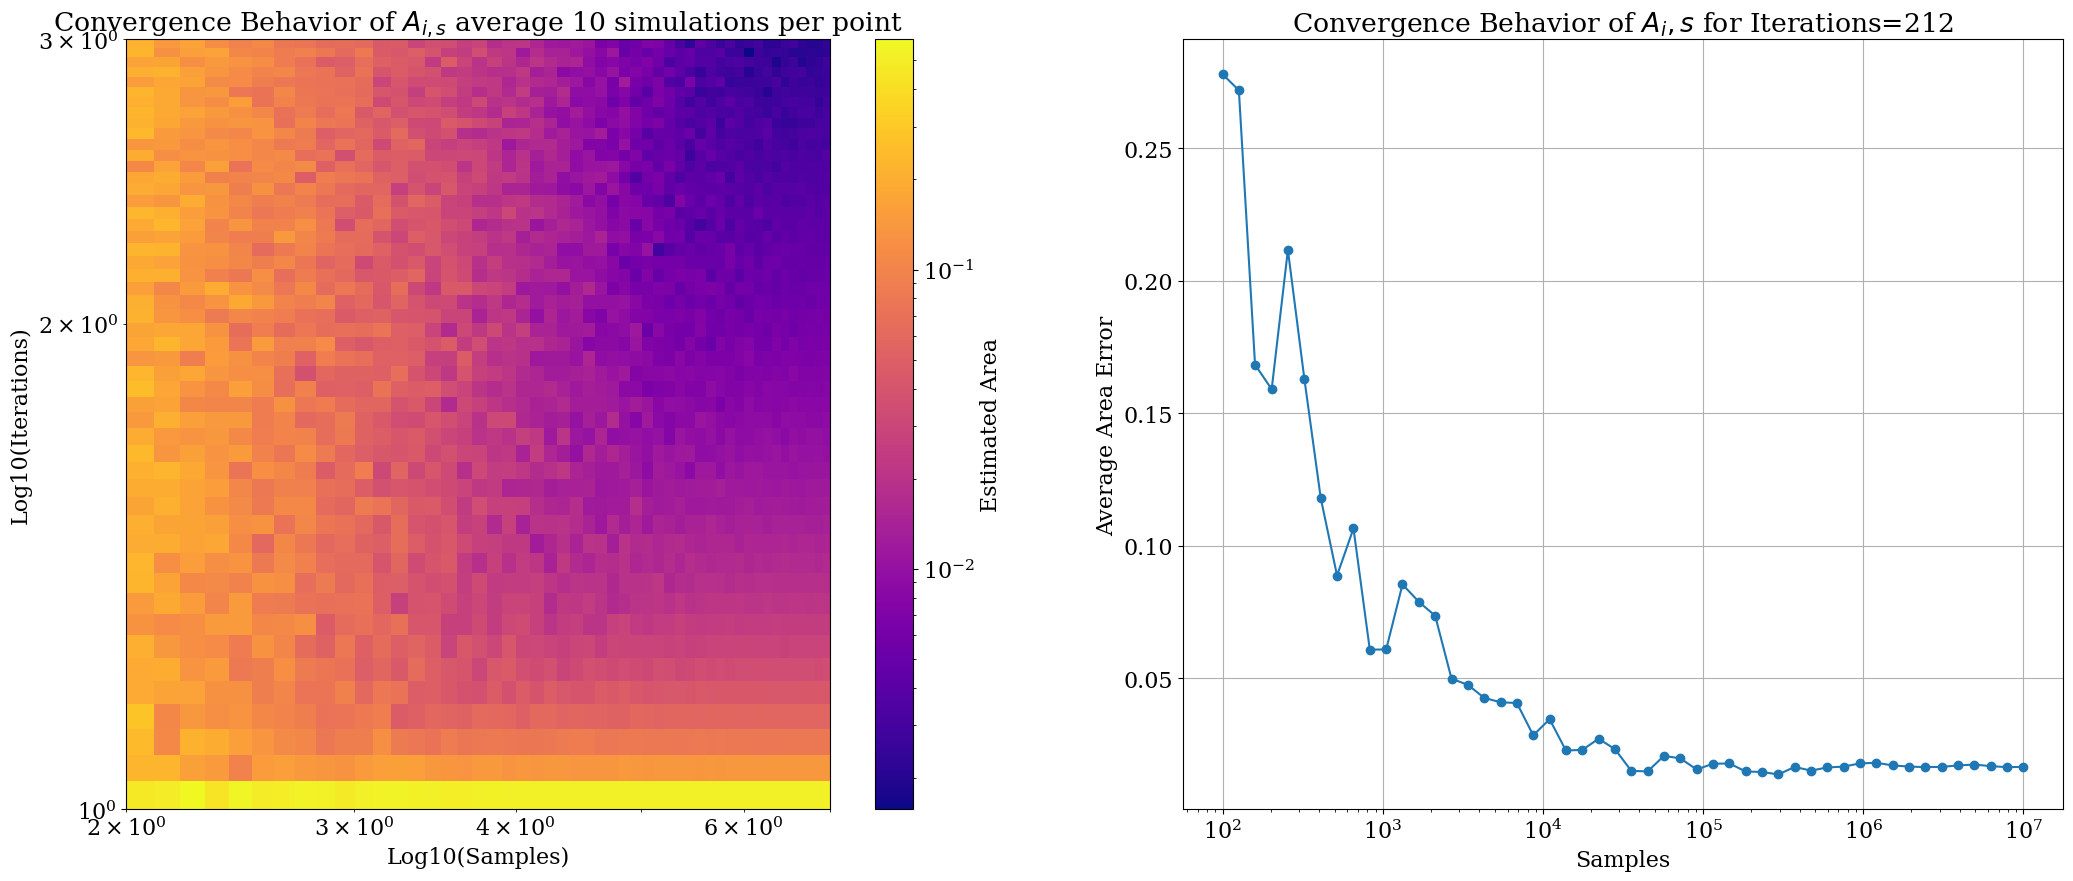

In [29]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,2, figsize=[25,10], gridspec_kw={'width_ratios': [1,1]})
# fig.tight_layout()

# plt.figure(figsize=(10, 8))
c = ax[0].imshow(LHS_areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[np.log10(samples[0]), np.log10(samples[-1]), np.log10(iterations[0]), np.log10(iterations[-1])])


fig.colorbar(c, label='Estimated Area', ax=ax[0])
ax[0].set_xlabel('Log10(Samples)')
ax[0].set_ylabel('Log10(Iterations)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].xaxis.set_ticks(np.log10(samples)[::10], samples[::10])
# ax[0].set_yticks(np.log10(iterations)[::10], iterations[::10])
ax[0].set_title('Convergence Behavior of $A_{i,s}$ average 10 simulations per point')

# Additional Line plot for specific value of i
fixed_i_index = 10
ax[1].semilogx(samples, areas[fixed_i_index, :], '-o')
ax[1].grid(True)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Average Area Error')
ax[1].set_title(f'Convergence Behavior of $A_{"i,s"}$ for Iterations={iterations[fixed_i_index]}')


### Orthogonal LHS sampling

In [122]:
real_values = np.linspace(-2, 1, 10000)
imaginary_values = np.linspace(-1.5, 1.5, 10000)

# mandel_ours = mandelbrot_set(real_values, imaginary_values, max_iter=1500)
orth_A = orthogonal(25000000, mandelbrot)

# found at: https://www2.pd.infn.it/~lacaprar/Didattica/C++/Complex/Area%20of%20the%20Mandelbrot%20Set.pdf
A_m_theory = 1.506484
print(f"The area of the Mandelbrot set (theory) is {A_m_theory:.4f}")
print(f"The area of the Mandelbrot set according to our orthogonal LHS (s=10m, i= 1000) is {orth_A}")


The area of the Mandelbrot set (theory) is 1.5065
The area of the Mandelbrot set according to our orthogonal LHS (s=10m, i= 1000) is 1.51375716


Orthogonal LHS data generation

In [52]:
iterations = np.linspace(10,1000,50, dtype=int)  # From 10^0=1 to 10^3=1000, 50 points
samples = np.logspace(2, 7, 50, dtype=int)  # From 10^2=100 to 10^6=1,000,000, 50 points

# Initialize the areas array to be of shape (len(iterations), len(samples))
ortho_areas = np.zeros((len(iterations), len(samples)))

real_values = np.linspace(-2, 1, 2000)
imaginary_values = np.linspace(-1.5, 1.5, 2000)


for i, iter in enumerate(iterations):
    print(f"Current iteration is {iter}")
    # mandelbrot_array = mandelbrot_set(real_values, imaginary_values, max_iter=iter)
    
    for j, s in enumerate(samples):
        for _ in range(15):
            area_dx = np.abs(orthogonal(s, M_sets_iter[i]) - A_m_theory) / 15
            ortho_areas[i, j] += area_dx

Current iteration is 10
Current iteration is 30
Current iteration is 50
Current iteration is 70
Current iteration is 90
Current iteration is 111
Current iteration is 131
Current iteration is 151
Current iteration is 171
Current iteration is 191
Current iteration is 212
Current iteration is 232
Current iteration is 252
Current iteration is 272
Current iteration is 292
Current iteration is 313
Current iteration is 333
Current iteration is 353
Current iteration is 373
Current iteration is 393
Current iteration is 414
Current iteration is 434
Current iteration is 454
Current iteration is 474
Current iteration is 494
Current iteration is 515
Current iteration is 535
Current iteration is 555
Current iteration is 575
Current iteration is 595
Current iteration is 616
Current iteration is 636
Current iteration is 656
Current iteration is 676
Current iteration is 696
Current iteration is 717
Current iteration is 737
Current iteration is 757
Current iteration is 777
Current iteration is 797
Curre

In [55]:
savetxt('orthognal.csv', ortho_areas, delimiter=',')

Text(0.5, 1.0, 'Convergence Behavior of $A_i,s$ for Iterations=212')

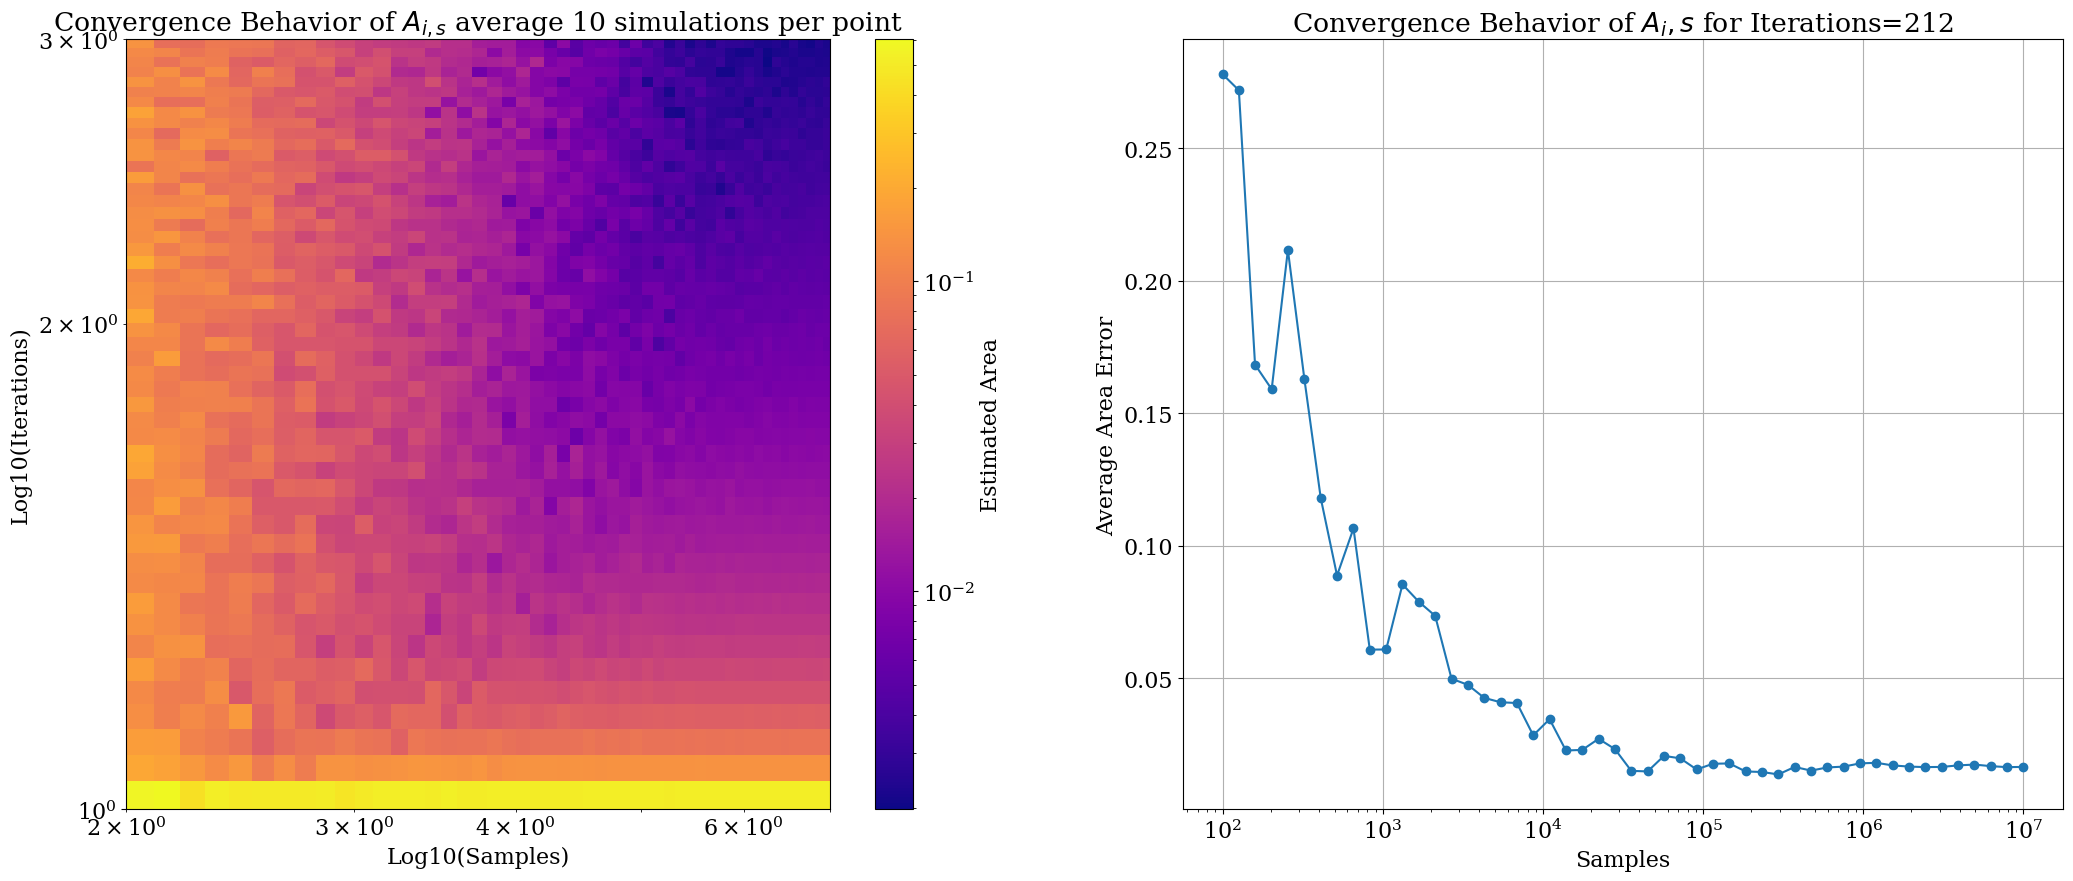

In [30]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,2, figsize=[25,10], gridspec_kw={'width_ratios': [1,1]})
# fig.tight_layout()

# plt.figure(figsize=(10, 8))
c = ax[0].imshow(orth_areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[np.log10(samples[0]), np.log10(samples[-1]), np.log10(iterations[0]), np.log10(iterations[-1])])


fig.colorbar(c, label='Estimated Area', ax=ax[0])
ax[0].set_xlabel('Log10(Samples)')
ax[0].set_ylabel('Log10(Iterations)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].xaxis.set_ticks(np.log10(samples)[::10], samples[::10])
# ax[0].set_yticks(np.log10(iterations)[::10], iterations[::10])
ax[0].set_title('Convergence Behavior of $A_{i,s}$ average 10 simulations per point')

# Additional Line plot for specific value of i
fixed_i_index = 10
ax[1].semilogx(samples, areas[fixed_i_index, :], '-o')
ax[1].grid(True)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Average Area Error')
ax[1].set_title(f'Convergence Behavior of $A_{"i,s"}$ for Iterations={iterations[fixed_i_index]}')


In [ ]:

print("Estimated area of the Mandelbrot set using adaptive strata:", round(estimated_area,4))
print("Estimated area of the Mandelbrot set using standard MC:", round(A_m_ours_no_array,4))
print("Estimated area of the Mandelbrot set according to theory:" ,round(A_m_theory,4))

### Comparing the sampling methods

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

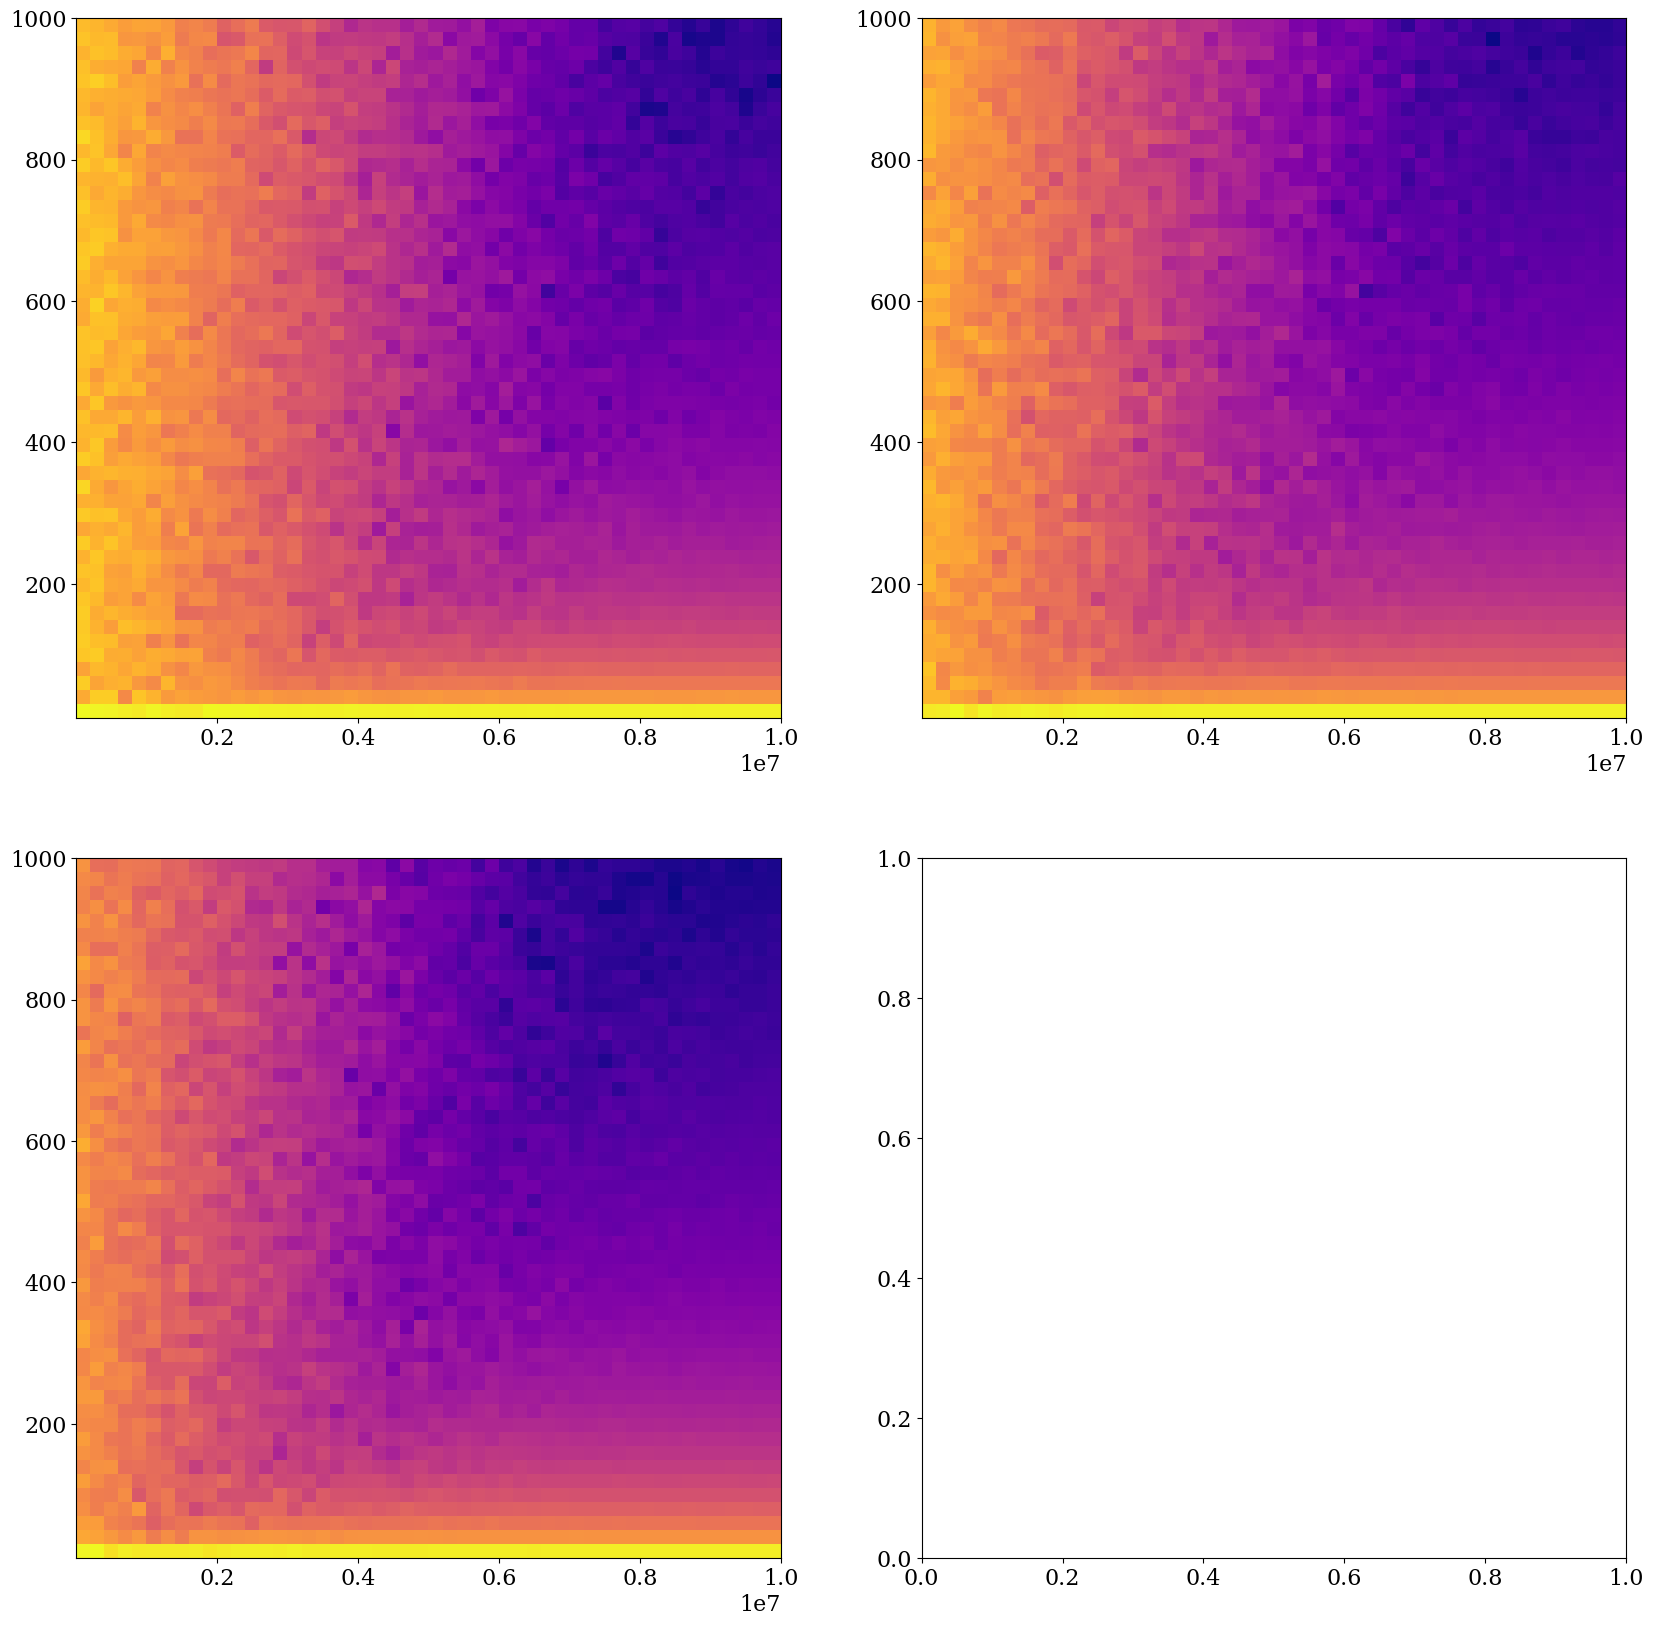

In [35]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(2,2, figsize=[20,20], gridspec_kw={'width_ratios': [1,1]})
# fig.tight_layout()

# plt.figure(figsize=(10, 8))
random_c = ax[0][0].imshow(areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[samples[0], samples[-1], iterations[0], iterations[-1]])
lhs_c = ax[0][1].imshow(LHS_areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[samples[0], samples[-1], iterations[0], iterations[-1]])

orth_c = ax[1][0].imshow(orth_areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[samples[0], samples[-1], iterations[0], iterations[-1]])

# fig.colorbar(random_c, label='Estimated Area')
ax[0].set_xlabel('Log10(Samples)')
ax[0].set_ylabel('Log10(Iterations)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].xaxis.set_ticks(np.log10(samples)[::10], samples[::10])
# ax[0].set_yticks(np.log10(iterations)[::10], iterations[::10])
ax[0].set_title('Convergence Behavior of $A_{i,s}$ average 10 simulations per point')

# # Additional Line plot for specific value of i
# fixed_i_index = 10
# ax[1].semilogx(samples, areas[fixed_i_index, :], '-o')
# ax[1].grid(True)
# ax[1].set_xlabel('Samples')
# ax[1].set_ylabel('Average Area Error')
# ax[1].set_title(f'Convergence Behavior of $A_{"i,s"}$ for Iterations={iterations[fixed_i_index]}')


AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

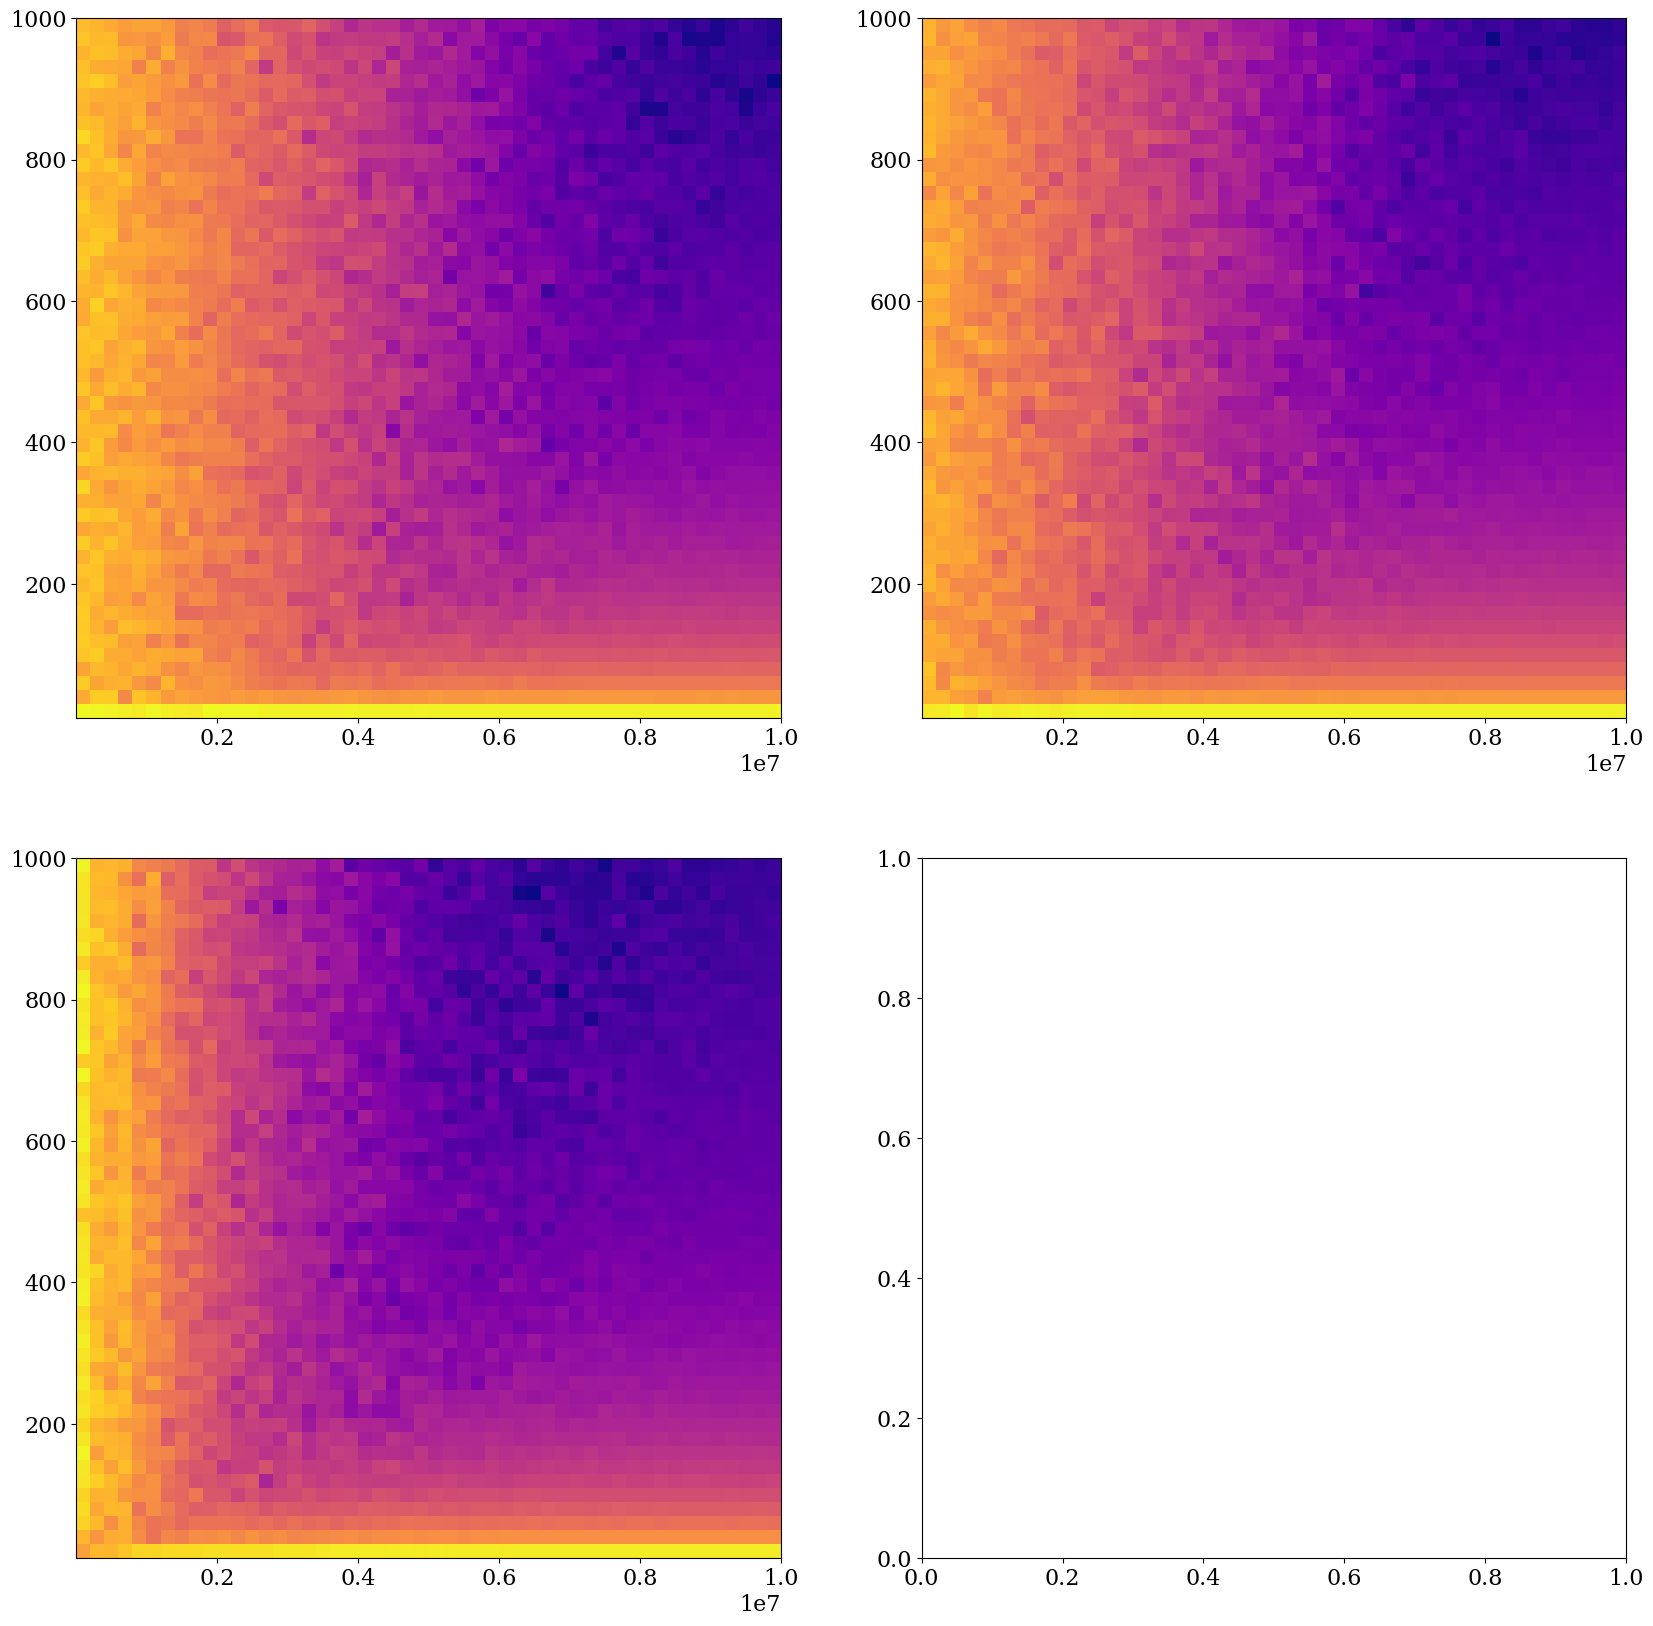

In [47]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(2,2, figsize=[20,20], gridspec_kw={'width_ratios': [1,1]})
# fig.tight_layout()

# plt.figure(figsize=(10, 8))
random_c = ax[0][0].imshow(areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[samples[0], samples[-1], iterations[0], iterations[-1]])
lhs_c = ax[0][1].imshow(LHS_areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[samples[0], samples[-1], iterations[0], iterations[-1]])

orth_c = ax[1][0].imshow(orth_areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[samples[0], samples[-1], iterations[0], iterations[-1]])

# fig.colorbar(random_c, label='Estimated Area')
ax[0].set_xlabel('Log10(Samples)')
ax[0].set_ylabel('Log10(Iterations)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].xaxis.set_ticks(np.log10(samples)[::10], samples[::10])
# ax[0].set_yticks(np.log10(iterations)[::10], iterations[::10])
ax[0].set_title('Convergence Behavior of $A_{i,s}$ average 10 simulations per point')

# # Additional Line plot for specific value of i
# fixed_i_index = 10
# ax[1].semilogx(samples, areas[fixed_i_index, :], '-o')
# ax[1].grid(True)
# ax[1].set_xlabel('Samples')
# ax[1].set_ylabel('Average Area Error')
# ax[1].set_title(f'Convergence Behavior of $A_{"i,s"}$ for Iterations={iterations[fixed_i_index]}')


### naam van area invullen lol

In [159]:
real = np.linspace (-0.777120613150274923773,-0.777120273471042550002,5000)
imaginary = np.linspace (0.126857111509958518545,0.126857366062765260933,5000)

# creates a 2D array of the mandelbrot set 
mandelbrot = mandelbrot_set(real, imaginary, max_iter=1000).T

plt.figure(figsize=[12,8])
plt.imshow(mandelbrot, extent = [-0.777120613150274923773,-0.777120273471042550002,0.126857111509958518545,0.126857366062765260933], cmap='magma')
plt.title('Elephant valley')
plt.xlabel('Real axis')
plt.ylabel('Imaginar axis')
plt.savefig("Fractal_zoom.png",dpi= 5000)
plt.show()

KeyboardInterrupt: 

### Elephant valley

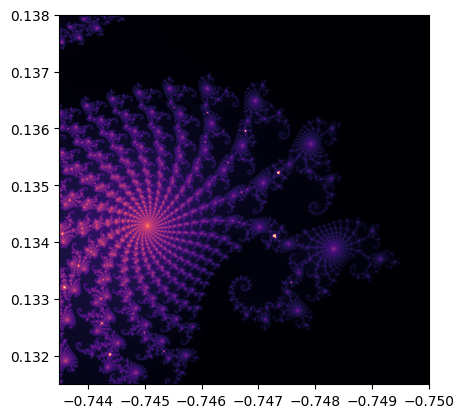

In [5]:
# elephant valley
real = np.linspace (-0.7435,-0.75,5000)
imaginary = np.linspace (0.1315,0.138,5000)

# creates a 2D array of the mandelbrot set 
mandelbrot = mandelbrot_set(real, imaginary, max_iter=1000).T

plt.imshow(mandelbrot, extent = [-0.7435,-0.75,0.1315,0.138], cmap='magma')
plt.savefig("Fractal_zoom.png",dpi= 5000)
plt.show()